In [1]:
!ls
# !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

 augment_v2				    rsna_metrics.py
 __pycache__				    rsna_model.py
 roi					   'rsna trainer.ipynb'
 roi_v2					    rsna_train_utils.py
'RSNA-BreastCancer Pipeline(Torch).ipynb'   train_predictions.csv
 rsna_dataset.py			    train-pytorch-rsna.ipynb


In [2]:
!pwd


/backup/HOME/mobassir/kaggle_competitions/rsna_breast_cancer/rsna_baseline


In [3]:
!nvidia-smi

import gc
import os
import sys
import cv2
import glob
import json
import shutil

import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold,GroupKFold
from torch import nn
from torch.utils.data import WeightedRandomSampler,RandomSampler

from torch.optim.lr_scheduler import StepLR, ExponentialLR

from warmup_scheduler import GradualWarmupScheduler

import torch

from pytorch_ranger import Ranger

import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import binary_cross_entropy_with_logits, cross_entropy

from rsna_dataset import BreastCancerDataset
from rsna_model import BreastCancerModel,save_model,load_model_weights
from rsna_metrics import *
from rsna_train_utils import train_fnc,gen_predictions
from torchsampler import ImbalancedDatasetSampler
import bitsandbytes as bnb
from tqdm import tqdm
from joblib import Parallel, delayed
print(torch.__version__)

Mon Feb 20 21:14:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:65:00.0 Off |                  Off |
| 30%   33C    P2    53W / 300W |   5902MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from rsna_dataset import CFG as Dataset_CFG
from rsna_model import CFG as Model_CFG
from rsna_train_utils import CFG as train_utils_CFG

# avail_pretrained_models = timm.list_models(pretrained=True)
# len(avail_pretrained_models), avail_pretrained_models[:]


In [5]:

class CFG:
    """
    Parameters used for training
    """
    seed = 42
    verbose = 1
    cv = 'StratifiedGroupKFold' #GroupKFold StratifiedGroupKFold StratifiedKFold
    
    save_weights = True
    freeze = False
    balanced_df = True
    img_size = (1024, 1024)
    batch_size = 24
    epochs = 10
    model_name = "tf_efficientnetv2_s"#efficientnet_b2 resnetv2_50d_gn resnet200d dm_nfnet_f3 tf_efficientnetv2_s tf_efficientnetv2_b3 dm_nfnet_f0
    fp16 = True
    n_folds = 4
    use_full = True
    train_folds = [0]
    clf_threshold = 0.1
    weight_decay = 1e-2
    lr = 2e-4
    warmup_factor = 10
    warmup_epo = 1
    lr_div = 1.0
    lr_final_div = 10000.0
    fc_dropout = 0.1
    opt_8bit = False
    grad_ckpt = False
    num_workers = 4
    sampler = 'BalancedSampler'
    SAVE_FOLDER = "../trained_folds/"
    n_channels = 1
    num_classes = 1
    pos_weight = 1.0
    tta = False


Model_CFG.model_name = CFG.model_name
Model_CFG.grad_ckpt = CFG.grad_ckpt
Model_CFG.fc_dropout = CFG.fc_dropout
Model_CFG.img_size = CFG.img_size

Dataset_CFG.img_size = CFG.img_size

train_utils_CFG.pos_weight = CFG.pos_weight
train_utils_CFG.fp16 = CFG.fp16
train_utils_CFG.epochs = CFG.epochs
train_utils_CFG.clf_threshold = CFG.clf_threshold

train_utils_CFG.lr = CFG.lr
train_utils_CFG.tta = CFG.tta
train_utils_CFG.batch_size = CFG.batch_size
train_utils_CFG.SAVE_FOLDER = CFG.SAVE_FOLDER

IMG_PATH = "../dieter_rsna_1024/output/"


os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f'SEED {seed}')
    
set_seed(CFG.seed)

SEED 42


In [7]:
train = pd.read_csv("../train.csv")

# idx = train[train.image_id == 1942326353].index
# train.drop(idx , inplace=True)
# print(idx)
train = train[train.image_id != 1942326353].reset_index(inplace=False) #822_1942326353
if(CFG.balanced_df):
    pos = train.query('cancer==1')
    neg = train.query('cancer==0')
    train = pd.concat([
        train.query('cancer==1'),  
#         train.query('cancer==0')
#         train.query('cancer==1'),
#         train.query('cancer==1')

        train.query('cancer==0').sample(n=len(pos)*46, random_state=CFG.seed)
    ], ignore_index=True)


test = pd.read_csv("../test.csv")
sample = pd.read_csv("../sample_submission.csv")

In [8]:
train.head(2)

,index,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False
1,88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False


<AxesSubplot: xlabel='cancer', ylabel='Count'>

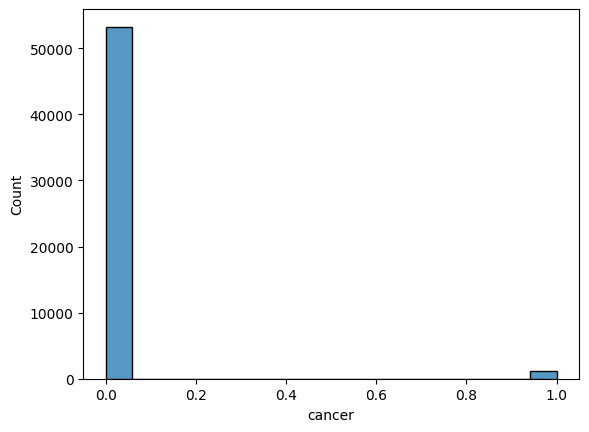

In [9]:
sns.histplot(data=train, x="cancer")

In [10]:

train["path"] = IMG_PATH + train["patient_id"].astype(str)  +"_"+ train["image_id"].astype(str) + ".png"
train.path[0]

'../dieter_rsna_1024/output/10130_388811999.png'

In [11]:
!ls /backup/HOME/mobassir/kaggle_competitions/rsna_breast_cancer/rsna_baseline/roi

augmented_dataset  augmented_df.csv  __results___files


In [12]:
aug_df = pd.read_csv('/backup/HOME/mobassir/kaggle_competitions/rsna_breast_cancer/rsna_baseline/roi/augmented_df.csv')

IMG_PATH1 = '/backup/HOME/mobassir/kaggle_competitions/rsna_breast_cancer/rsna_baseline/roi/augmented_dataset/'
aug_df["path"] = IMG_PATH1 + aug_df["aug_img_name"].astype(str)


aug_df1 = pd.read_csv('/backup/HOME/mobassir/kaggle_competitions/rsna_breast_cancer/rsna_baseline/augment_v2/augmented_df.csv')

IMG_PATH2 = '/backup/HOME/mobassir/kaggle_competitions/rsna_breast_cancer/rsna_baseline/augment_v2/augmented_dataset/'
aug_df1["path"] = IMG_PATH2 + aug_df1["aug_img_name"].astype(str)


aug_df2 = pd.read_csv('/backup/HOME/mobassir/kaggle_competitions/rsna_breast_cancer/rsna_baseline/roi_v2/augmented_df.csv')

IMG_PATH3 = '/backup/HOME/mobassir/kaggle_competitions/rsna_breast_cancer/rsna_baseline/roi_v2/augmented_dataset/'
aug_df2["path"] = IMG_PATH3 + aug_df2["aug_img_name"].astype(str)


aug_df2.head(1)

,index,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path,img_name,aug_img_name
0,87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False,/backup/HOME/mobassir/kaggle_competitions/rsna...,10130_388811999.png,aug_10130_388811999.png


In [13]:
aug_df1.path[0]

'/backup/HOME/mobassir/kaggle_competitions/rsna_breast_cancer/rsna_baseline/augment_v2/augmented_dataset/aug_10130_388811999.png'

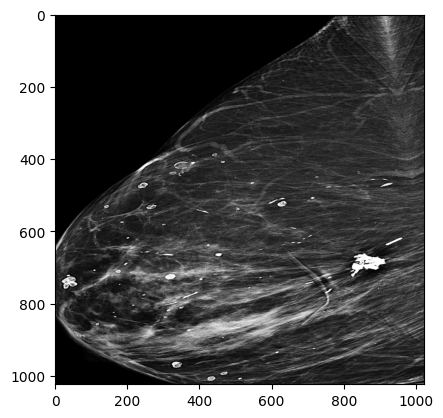

In [14]:
plt.imshow(cv2.imread(aug_df.path[0]))

In [15]:
strat_cols = [
    'laterality', 'view', 'biopsy','invasive', 'BIRADS', 'age',
    'implant', 'density','machine_id', 'difficult_negative_case',
    'cancer',
]

train['stratify'] = ''
for col in strat_cols:
    train['stratify'] += train[col].astype(str)
    
if(CFG.cv == 'GroupKFold'):
    print('GroupKFold')
    gkf = GroupKFold(n_splits=CFG.n_folds)
    train['fold']=-1
    for group, df_group in train.groupby('cancer'):
        indices = list(df_group.index)
        for f, (t, v) in enumerate(gkf.split(X=df_group, groups=df_group.patient_id)):
            the_indices = np.array(indices)[v]
            train.loc[the_indices, 'fold']=f
elif(CFG.cv == 'StratifiedKFold'):
    print('StratifiedKFold')
    train['fold']= -1
    cv = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)

    for fold, (_, valid_idx) in enumerate(cv.split(X=train["image_id"], y=train["cancer"], groups=train["patient_id"])):
        train.loc[valid_idx, "fold"] = fold
else:
    print('StratifiedGroupKFold')
    train['fold']= -1
    cv = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)

#     for fold, (_, valid_idx) in enumerate(cv.split(X=train["image_id"], y=train["cancer"], groups=train["patient_id"])):
    for fold, (_, valid_idx) in enumerate(cv.split(train, train['stratify'].values, train['patient_id'].values)):
        train.loc[valid_idx, "fold"] = fold

assert train.groupby(['fold', 'cancer']).size().sum() == train.shape[0]

StratifiedGroupKFold


/home/ansary/anaconda3/envs/mobassir/lib/python3.8/site-packages/sklearn/model_selection/_split.py:885: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


In [16]:
train.groupby("fold")["cancer"].value_counts()


fold  cancer
0     0         13191
      1           298
1     0         13270
      1           281
2     0         13409
      1           294
3     0         13398
      1           285
Name: cancer, dtype: int64

<AxesSubplot: xlabel='fold', ylabel='Count'>

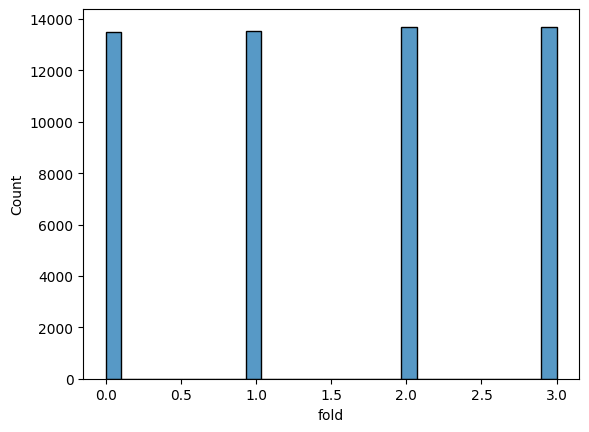

In [17]:
sns.histplot(data=train, x="fold")

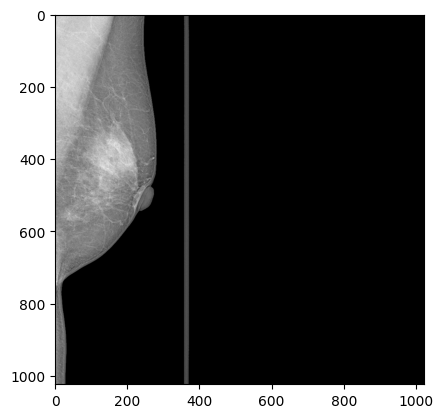

In [18]:
img_file = '../1024x1024_pngs/output/10006_1459541791.png' #'822_1942326353.png 10006_1459541791.png' 822_1942326353
plt.imshow(cv2.imread(img_file), cmap="bone")

In [19]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if len(param.shape) == 1 or np.any([v in name.lower()  for v in skip_list]):
            # print(name, 'no decay')
            no_decay.append(param)
        else:
            # print(name, 'decay')
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]


  

torch.Size([24, 1, 1024, 1024]) torch.Size([24])


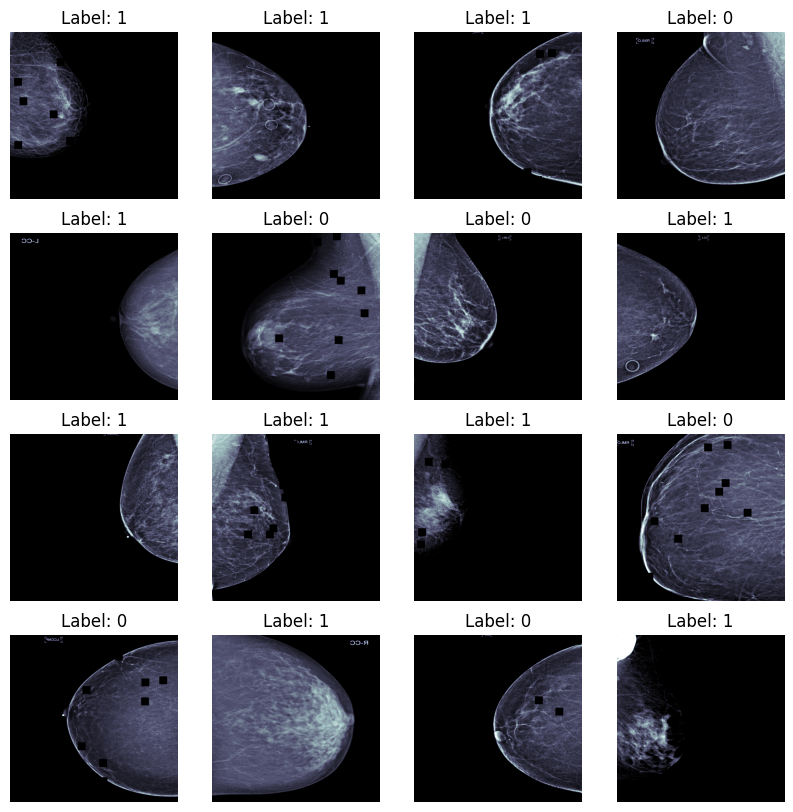

In [20]:
#https://www.kaggle.com/code/truthisneverlinear/rsna-efficientnetv2-xl-pytorch

def show_aug(inputs, targets, nrows=4, ncols=4, norm=False):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    i_ = 0
    
    if len(inputs) > 16:
        inputs = inputs[:16]
        
    for idx in range(len(inputs)):
    
        # normalization
        if norm:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        plt.subplot(nrows, ncols, i_+1)
        plt.title(f"Label: {targets[idx].item()}")
        plt.imshow(img, cmap="bone"); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

train_df = train[train["fold"] != 1]

train_dataset = BreastCancerDataset(train_df, transforms="train")
sampler = ImbalancedDatasetSampler(train_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, sampler = sampler, shuffle=False, num_workers=CFG.num_workers)

images, targets = next(iter(train_dataloader))
print(images.shape, targets.shape)

show_aug(images, targets)
del train_dataloader,train_dataset

In [ ]:
%%time


def make_fold(fold=0,df=train):
    patient_id = df.patient_id.unique()
    patient_id = sorted(patient_id)

    num_fold=5
    rs = np.random.RandomState(777)
    rs.shuffle(patient_id)
    patient_id = np.array(patient_id)
    f = np.arange(len(patient_id))%num_fold
    train_id = patient_id[f!=fold]
    valid_id = patient_id[f==fold]

    train_df = df[df.patient_id.isin(train_id)].reset_index(drop=True)
    valid_df = df[df.patient_id.isin(valid_id)].reset_index(drop=True)
    return train_df, valid_df

    
class BalanceSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, ratio= CFG.batch_size // 2):
        self.r = ratio-1
        self.dataset = dataset
        self.pos_index = np.where(dataset.targets>0)[0]
        self.neg_index = np.where(dataset.targets==0)[0]

        self.length = self.r*int(np.floor(len(self.neg_index)/self.r))

    def __iter__(self):
        pos_index = self.pos_index.copy()
        neg_index = self.neg_index.copy()
        np.random.shuffle(pos_index)
        np.random.shuffle(neg_index)

        neg_index = neg_index[:self.length].reshape(-1,self.r)
        pos_index = np.random.choice(pos_index, self.length//self.r).reshape(-1,1)

        index = np.concatenate([pos_index,neg_index],-1).reshape(-1)
        return iter(index)

    def __len__(self):
        return self.length

for fold in range(CFG.n_folds):
    if fold not in CFG.train_folds: continue
        
    
    #     train_df,valid_df = make_fold(fold=fold,df = train)
    if(CFG.use_full):
        print("training on 100% of the dataset")
        train_df = train
        valid_df = train
    else:
        print("*"*10, f"Training Fold: {fold}", "*"*10)
        train_df = train[train["fold"] != fold]
        valid_df = train[train["fold"] == fold]
    

    imgs = []
    tr = train_df.query('cancer==1').reset_index(drop=True)
    for idx in range(len(tr)):
        head, tail = os.path.split(tr.path[idx])
        imgs.append(tail)
    
    for i in range(len(imgs)):
        train_df = pd.concat([train_df, aug_df[aug_df['img_name'] == imgs[i]]])#roi
        train_df = pd.concat([train_df, aug_df1[aug_df1['img_name'] == imgs[i]]])#aug_v2
        train_df = pd.concat([train_df, aug_df2[aug_df2['img_name'] == imgs[i]]])#roi_v2



   
    train_df = pd.concat([
#         train_df.query('cancer==1'),
#         train_df.query('cancer==1'),
        train_df.query('cancer==0'),
#         train_df.query('cancer==1'),
#         train_df.query('cancer==1'),
#         train_df.query('cancer==1'),
#         train_df.query('cancer==1'),
#         train_df.query('cancer==1'),
#         train_df.query('cancer==1'),
#         train_df.query('cancer==1'),
        train_df.query('cancer==1')
       ], ignore_index=True)
 
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    
    pos = len(train_df.query('cancer==1'))
    neg = len(train_df.query('cancer==0'))
    substracted = neg - pos
    weight = substracted/neg
            
    train_utils_CFG.pos_weight = weight
    print("weight........",train_utils_CFG.pos_weight)  
    
    print(train_df.cancer.value_counts(),valid_df.cancer.value_counts())
    train_dataset = BreastCancerDataset(train_df, transforms="train")
    valid_dataset = BreastCancerDataset(valid_df, transforms="valid")
    
    if(CFG.sampler == 'WeightedRandomSampler'):
        print("WeightedRandomSampler")
#         class_counts = train_df.cancer.value_counts()
#         class_weights = 1/class_counts
#         sample_weights = [1/class_counts[i] for i in train_df.cancer.values]
        labels = train_df['cancer'].values
        class_sample_count = np.array([len(np.where(labels == l)[0]) for l in np.unique(labels)])

        class_sample_count[1] *= 5
        class_weights = 1. / class_sample_count
        
        sample_weights = []
        for _, label in tqdm(train_dataset):
            sample_weights.append(class_weights[label])

        sample_weights = np.array(sample_weights)
        sample_weights = torch.from_numpy(sample_weights)

        shuffle = False
        sampler= WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)
    elif (CFG.sampler == 'ImbalancedDatasetSampler'):
        print(".......ImbalancedDatasetSampler(train_dataset).........")
        sampler = ImbalancedDatasetSampler(train_dataset)
        shuffle = False
    elif (CFG.sampler == 'RandomSampler'): 
        print("RandomSampler")
        sampler = RandomSampler(train_dataset)
        shuffle = False
    else: 
        print("BalancedSampler")
        sampler= BalanceSampler(train_dataset)
        shuffle = False
    #, sampler = sampler, shuffle=shuffle
    train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, sampler = sampler, shuffle=shuffle, drop_last=True, num_workers=CFG.num_workers)

#     train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size,  shuffle=True, num_workers=CFG.num_workers)
    valid_dataloader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False,  num_workers=CFG.num_workers)

#     model = BreastCancerModel(CFG.model_name, n_meta_features=0, out_dim=CFG.num_classes).to(device) 

    model = BreastCancerModel(
    model_name = CFG.model_name,
    num_classes=CFG.num_classes,
    n_channels=CFG.n_channels)

    if(fold < 1):
        print(model)
    model = model.to(device) 
    
    if(CFG.opt_8bit):
        model_parameters = filter(lambda parameter: parameter.requires_grad, model.parameters()) 
        optimizer = bnb.optim.AdamW(params=model_parameters, lr=CFG.lr, weight_decay=CFG.weight_decay, optim_bits=8)
    else:        
        optimizer = torch.optim.AdamW(
                 add_weight_decay(model,
                                  weight_decay=CFG.weight_decay,
                                  skip_list=['bias']),
                 lr=CFG.lr,
                 betas=(0.9, 0.999),
                 weight_decay=CFG.weight_decay)
        
#         optimizer = torch.optim.RAdam(model.parameters(), lr=CFG.lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, foreach=None)
    
#         optimizer =  Ranger(model.parameters(), lr=CFG.lr)

             
    
    model = nn.DataParallel(model)
    
#     scheduler = None
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1,max_lr=CFG.lr, epochs=CFG.epochs, steps_per_epoch=int(len(train_dataset)),anneal_strategy="cos",div_factor=CFG.lr_div,final_div_factor=CFG.lr_final_div)

#     scheduler_warmup is chained with schduler_steplr
#     scheduler_steplr = StepLR(optimizer, step_size=10, gamma=0.1)

#     scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CFG.epochs-CFG.warmup_epo)
    
#     scheduler = GradualWarmupScheduler(optimizer, multiplier=CFG.warmup_factor, total_epoch=CFG.epochs, after_scheduler=scheduler_cosine)
    
    train_fnc(train_dataloader, valid_dataloader, model, fold, optimizer, scheduler)
    
#     del model,optimizer, scheduler
#     gc.collect()
#     torch.cuda.empty_cache()



training on 100% of the dataset
weight........ 0.9130434782608695
0    53268
1     4632
Name: cancer, dtype: int64 0    53268
1     1158
Name: cancer, dtype: int64
BalancedSampler
BreastCancerModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(1, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

Train: Epoch 1:   0%|            | 0/2219 [00:03<?, ?it/s, loss=8.27, lr=0.0002]

old_scaler  65536.0 new_scaler  32768.0


Train: Epoch 1:   0%|            | 0/2219 [00:03<?, ?it/s, loss=11.5, lr=0.0002]

old_scaler  32768.0 new_scaler  16384.0


Train: Epoch 1:   0%|            | 0/2219 [00:04<?, ?it/s, loss=9.52, lr=0.0002]

old_scaler  16384.0 new_scaler  8192.0


Train: Epoch 1:   0%|     | 4/2219 [00:05<49:30,  1.34s/it, loss=6.4, lr=0.0002]

old_scaler  8192.0 new_scaler  4096.0


Train: Epoch 1:   0%|    | 4/2219 [00:06<49:30,  1.34s/it, loss=11.6, lr=0.0002]

old_scaler  4096.0 new_scaler  2048.0


Train: Epoch 1:   0%|    | 4/2219 [00:06<49:30,  1.34s/it, loss=3.75, lr=0.0002]

old_scaler  2048.0 new_scaler  1024.0


Train: Epoch 1:   0%|    | 4/2219 [00:07<49:30,  1.34s/it, loss=7.38, lr=0.0002]

old_scaler  1024.0 new_scaler  512.0


Train: Epoch 1:   0%|    | 4/2219 [00:08<49:30,  1.34s/it, loss=12.3, lr=0.0002]

old_scaler  512.0 new_scaler  256.0


Train: Epoch 1:   0%|    | 11/2219 [00:10<33:51,  1.09it/s, loss=4.7, lr=0.0002]

old_scaler  256.0 new_scaler  128.0


Train: Epoch 1:   0%|   | 11/2219 [00:12<33:51,  1.09it/s, loss=11.9, lr=0.0002]

old_scaler  128.0 new_scaler  64.0


Train: Epoch 1:   0%|   | 11/2219 [00:14<33:51,  1.09it/s, loss=15.3, lr=0.0002]

old_scaler  64.0 new_scaler  32.0


Train: Epoch 1: 2421it [29:26,  1.37it/s, loss=1.13, lr=0.0002]                 
Eval: 1: 100%|█| 2268/2268 [08:37<00:00,  4.38it/s, loss=tensor(0.0447, device='


pf1 ->  0.09141830424693065  *** bin_score for 0.2 threshold ->  0.1284686536485098
groupby mean()  	 auc 0.70444	 threshold 0.42857	 f1score 0.15363 | 	 pf1score 0.15443	 pthr 0.42121 	 precision 0.20982	 recall 0.12176 | 	 sensitivity 0.12263	 specificity 0.99003

----------> Validation AUC =  0.7044361937285091  valid thresholded probabilistic_f1 =  0.15442764578833693  for threshold =  0.4212105263157895
>>>>>>>New Best Score

-------- Epoch 1 --------
Train Loss:  0.7832060927980159
Valid Loss:  0.09272893150769086
pF1:  0.15442764578833693
Best Score:  0.15442764578833693



Train: Epoch 2: 2421it [29:27,  1.37it/s, loss=0.00075, lr=0.0002]              
Eval: 2: 100%|█| 2268/2268 [08:36<00:00,  4.39it/s, loss=tensor(0.0841, device='


pf1 ->  0.16557113819859953  *** bin_score for 0.2 threshold ->  0.239923682327689
groupby mean()  	 auc 0.83031	 threshold 0.40816	 f1score 0.28546 | 	 pf1score 0.28546	 pthr 0.42121 	 precision 0.28608	 recall 0.28584 | 	 sensitivity 0.28584	 specificity 0.98449

----------> Validation AUC =  0.830310459328221  valid thresholded probabilistic_f1 =  0.28546177640300485  for threshold =  0.4212105263157895
>>>>>>>New Best Score

-------- Epoch 2 --------
Train Loss:  0.43010110278439884
Valid Loss:  0.059234971772265846
pF1:  0.28546177640300485
Best Score:  0.28546177640300485



Train: Epoch 3: 2421it [29:09,  1.38it/s, loss=1.68, lr=0.0002]                 
Eval: 3: 100%|█| 2268/2268 [08:44<00:00,  4.33it/s, loss=tensor(0.0862, device='


pf1 ->  0.2005723093392167  *** bin_score for 0.2 threshold ->  0.2527565733672604
groupby mean()  	 auc 0.85544	 threshold 0.73469	 f1score 0.32067 | 	 pf1score 0.30454	 pthr 0.50000 	 precision 0.35072	 recall 0.29620 | 	 sensitivity 0.29620	 specificity 0.98808

----------> Validation AUC =  0.8554439842952695  valid thresholded probabilistic_f1 =  0.3045387994143484  for threshold =  0.5
>>>>>>>New Best Score

-------- Epoch 3 --------
Train Loss:  0.3783095215888281
Valid Loss:  0.08538878100362648
pF1:  0.3045387994143484
Best Score:  0.3045387994143484



Train: Epoch 4:  68%|▋| 1518/2219 [18:25<08:29,  1.37it/s, loss=0.965, lr=0.0002

old_scaler  512.0 new_scaler  256.0


Train: Epoch 4: 2295it [27:56,  1.38it/s, loss=0.131, lr=0.0002]                

In [ ]:
train.cancer.value_counts()

In [ ]:
valid_df

In [ ]:
os.cpu_count()

In [ ]:
42800/940


In [ ]:
print("-"*10, " BEST Probabilistic F1 ", "-"*10)
models_path = glob.glob("/backup/HOME/mobassir/kaggle_competitions/rsna_breast_cancer/trained_folds/*best_score.pth")

In [ ]:
models = [load_model_weights(nn.DataParallel(BreastCancerModel(model_name = CFG.model_name,num_classes=CFG.num_classes,n_channels=CFG.n_channels)).to(device), model)[0] for model in models_path]


In [ ]:
pred_df = gen_predictions(models, train)
pred_df.to_csv('train_predictions.csv', index=False)
!head train_predictions.csv

In [ ]:
pred_df = pd.read_csv('train_predictions.csv')
print('F1 CV score (multiple thresholds):', f1_score(pred_df.cancer, pred_df.cancer_pred))    
pred_df = pred_df.groupby(['patient_id', 'laterality']).agg(
    cancer_max=('cancer_pred_proba', 'max'), cancer_mean=('cancer_pred_proba', 'mean'), cancer=('cancer', 'max')
)
print('pF1 CV score. Mean aggregation, single threshold:', optimal_f1(pred_df.cancer.values, pred_df.cancer_mean.values))
print('pF1 CV score. Max aggregation, single threshold:', optimal_f1(pred_df.cancer.values, pred_df.cancer_max.values))

In [ ]:
pred_df = pd.read_csv('train_predictions.csv')

pred_df.head()

In [ ]:
pf1,thr = optimal_f1(pred_df.cancer.values, pred_df.cancer_pred_proba.values)

In [ ]:
pf1,thr 

In [ ]:

if __name__ == '__main__':

    pred_df.rename(columns = {'cancer_pred_proba':'cancer_p', 'cancer':'cancer_t'}, inplace = True)
    
    valid_df = pred_df
  
    print_all_metric(valid_df)


    gb = valid_df[['site_id', 'patient_id','laterality', 'cancer_t', 'cancer_p']].groupby(['patient_id', 'laterality']).mean()
    gb.loc[:, 'cancer_t'] = gb.cancer_t.astype(int)
    m = compute_metric(gb.cancer_p, gb.cancer_t)
    text = f'{"grouby mean()": <16}'
    text += f'\t{m["auc"]:0.5f}'
    text += f'\t{m["threshold"]:0.5f}'
    text += f'\t{m["f1score"]:0.5f} | '
    text += f'\t{m["precision"]:0.5f}'
    text += f'\t{m["recall"]:0.5f} | '
    text += f'\t{m["sensitivity"]:0.5f}'
    text += f'\t{m["specificity"]:0.5f}'
    text += '\n'
    print(text)

    pfbeta = compute_pfbeta(gb.cancer_t.values, gb.cancer_p.values, beta=1)
    print('pfbeta',pfbeta)
    plot_auc(gb.cancer_p, gb.cancer_t, figure_num=100)


    f1score, precision, recall, threshold = get_f1score(gb.cancer_p, gb.cancer_t)
    i = f1score.argmax()
    f1score_max, precision_max, recall_max, threshold_max = f1score[i], precision[i], recall[i], threshold[i]
    print(f1score_max, precision_max, recall_max, threshold_max)

    precision, recall, threshold = metrics.precision_recall_curve(gb.cancer_t, gb.cancer_p)
    auc = metrics.auc(recall, precision)

    _, ax = plt.subplots(figsize=(5, 5))

    f_scores = [0.2,0.3,0.4,0.5,0.6,0.7,0.8] #np.linspace(0.2, 0.8, num=8)
    print(f_scores)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))
    ax.plot([0,1],[0,1], color="gray", alpha=0.2)
    ax.plot(recall,precision)
    s=ax.scatter(recall[:-1],precision[:-1],c=threshold,cmap='hsv')
    ax.scatter(recall_max, precision_max,s=30,c='k')

    #---
    precision, recall, threshold = metrics.precision_recall_curve(gb.cancer_t[gb.site_id==1], gb.cancer_p[gb.site_id==1])
    ax.plot(recall,precision, '--', label='site_id=1')
    precision, recall, threshold = metrics.precision_recall_curve(gb.cancer_t[gb.site_id==2], gb.cancer_p[gb.site_id==2])
    ax.plot(recall,precision, '--', label='site_id=2')




    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    text=''
    text+=f'MAX f1score {f1score_max: 0.5f} @ th = {threshold_max: 0.5f}\n'
    text+=f'prec {precision_max: 0.5f}, recall {recall_max: 0.5f}, pr-auc {auc: 0.5f}\n'

    plt.legend()
    plt.title(text)
    plt.colorbar(s,label='threshold')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.show()




In [ ]:
!nvcc --version

In [ ]:
#!pip install bitsandbytes-cuda117
# !pip install pytorch_ranger
# !pip install -U albumentations[imgaug]

In [ ]:
#reference -> https://www.kaggle.com/code/vslaykovsky/train-pytorch-aux-targets-weighted-loss-thres

In [ ]:
# pf1 ->  0.8995561690910286  *** bin_score for 0.2 threshold ->  0.905997447894513
# groupby mean()  	 auc 0.99614	 threshold 0.48980	 f1score 0.92244 | 	 pf1score 0.92308	 pthr 0.47374 	 precision 0.95308	 recall 0.89465 | 	 sensitivity 0.89465	 specificity 0.99890

# ----------> Validation AUC =  0.9961411902183802  valid thresholded probabilistic_f1 =  0.9230769230769231  for threshold =  0.4737368421052632
# >>>>>>>New Best Score

# -------- Epoch 4 --------
# Train Loss:  0.0637414711267135
# Valid Loss:  0.003754362737689257
# pF1:  0.9230769230769231
# Best Score:  0.9230769230769231



# pf1 ->  0.9114435941559824  *** bin_score for 0.2 threshold ->  0.9115531104528142
# groupby mean()  	 auc 0.99582	 threshold 0.79592	 f1score 0.92265 | 	 pf1score 0.91920	 pthr 0.44747 	 precision 0.95648	 recall 0.89205 | 	 sensitivity 0.89206	 specificity 0.99910

# ----------> Validation AUC =  0.9958185056919251  valid thresholded probabilistic_f1 =  0.9192006950477845  for threshold =  0.4474736842105263
# >>>>>>>New Best Score

# -------- Epoch 5 --------
# Train Loss:  0.07393841317561649
# Valid Loss:  0.005410363865262289
# pF1:  0.9192006950477845
# Best Score:  0.9192006950477845
    

    
    
# pf1 ->  0.8493632634614606  *** bin_score for 0.2 threshold ->  0.8456742010911924
# groupby mean()  	 auc 0.99676	 threshold 0.67347	 f1score 0.88180 | 	 pf1score 0.87133	 pthr 0.47374 	 precision 0.87778	 recall 0.88687 | 	 sensitivity 0.88687	 specificity 0.99645

# ----------> Validation AUC =  0.9967647368396382  valid thresholded probabilistic_f1 =  0.8713280926768722  for threshold =  0.4737368421052632
# >>>>>>>New Best Score

# -------- Epoch 7 --------
# Train Loss:  0.022165576414460448
# Valid Loss:  0.018803071848546706
# pF1:  0.8713280926768722
# Best Score:  0.8713280926768722
    

In [ ]:
#1158